In [4]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import json
from datetime import datetime, timedelta
import pyarrow.dataset as ds
import warnings
warnings.filterwarnings('ignore')

print("✓ Imports successful")
print(f"Working directory: {Path.cwd()}")

# Verify Stage 1 data exists
data_path = Path("data/processed")
if not data_path.exists():
    print("⚠️ No processed data found. Please run Stage 1 first!")
else:
    print(f"✓ Found processed data in {data_path}")

✓ Imports successful
Working directory: c:\Users\alber\trader\notebooks
⚠️ No processed data found. Please run Stage 1 first!


In [5]:
# Cell 2: Load Data from Stage 1
def load_stage1_data():
    """Load data saved from Stage 1."""
    
    data_path = Path("data/processed")
    
    # Load consolidated price data
    price_file = data_path / "all_stocks_consolidated.parquet"
    if price_file.exists():
        print(f"Loading price data from {price_file}")
        price_df = pd.read_parquet(price_file, engine="pyarrow")
        print(f"  ✓ Loaded {len(price_df)} rows for {price_df['symbol'].nunique()} stocks")
    else:
        print("⚠️ No consolidated price file found. Trying partitioned data...")
        dataset = ds.dataset(data_path / "partitioned", format="parquet")
        price_df = dataset.to_table().to_pandas()
        print(f"  ✓ Loaded {len(price_df)} rows from partitions")
    
    # Load reference data
    ref_file = data_path / "reference_data.parquet"
    if ref_file.exists():
        ref_df = pd.read_parquet(ref_file,engine="pyarrow")
        print(f"  ✓ Loaded reference data for {len(ref_df)} stocks")
    else:
        print("  ⚠️ No reference data found")
        ref_df = pd.DataFrame()
    
    # Load metadata
    metadata_file = data_path / "metadata.json"
    if metadata_file.exists():
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        print(f"  ✓ Date range: {metadata['date_range']['start']} to {metadata['date_range']['end']}")
    
    return price_df, ref_df

# Load the data
price_data, reference_data = load_stage1_data()

# Display data sample
print("\nPrice data sample:")
print(price_data.head())
print("\nReference data sample:")
print(reference_data.head())

⚠️ No consolidated price file found. Trying partitioned data...


FileNotFoundError: data/processed/partitioned

In [5]:
# Cell 3: Define Coarse Filter Configuration
# These are the rule-based filters we'll apply

coarse_config = {
    'filters': {
        'price_min': 5.0,              # Minimum stock price
        'price_max': 10000.0,          # Maximum stock price (avoid BRK.A type stocks)
        'adv_usd_min': 2_000_000,      # Minimum 30-day average dollar volume
        'adv_percentile': 60,          # Top X% by dollar volume
        'volume_min': 100_000,         # Minimum daily volume
        'history_days_min': 756,       # Minimum trading history (~3 years)
        'exchanges': ['NYSE', 'NASDAQ', 'AMEX'],  # Valid exchanges
        'exclude_types': ['ETF', 'ETN', 'PREFERRED', 'OTC'],  # Exclude these
        'max_missing_pct': 0.10,       # Max 10% missing bars in last year
        'min_trading_days_pct': 0.95,  # Must trade 95% of possible days
    },
    'lookback_periods': {
        'volume_days': 30,             # Days for volume average
        'missing_days': 252,           # Days to check for missing data (1 year)
    }
}

print("Coarse Filter Configuration:")
print("-" * 50)
for category, params in coarse_config['filters'].items():
    print(f"{category:25} : {params}")

Coarse Filter Configuration:
--------------------------------------------------
price_min                 : 5.0
price_max                 : 10000.0
adv_usd_min               : 2000000
adv_percentile            : 60
volume_min                : 100000
history_days_min          : 756
exchanges                 : ['NYSE', 'NASDAQ', 'AMEX']
exclude_types             : ['ETF', 'ETN', 'PREFERRED', 'OTC']
max_missing_pct           : 0.1
min_trading_days_pct      : 0.95


In [7]:
# Cell 4: Calculate Metrics for Each Stock
def calculate_stock_metrics(price_data):
    """Calculate metrics needed for filtering."""
    
    print("Calculating metrics for each stock...")
    
    metrics = []
    
    # Group by symbol
    for symbol, group in price_data.groupby('symbol'):
        # Sort by date to ensure correct order
        group = group.sort_index()
        
        # Basic metrics
        metric = {
            'symbol': symbol,
            'total_days': len(group),
            'date_start': group.index[0],
            'date_end': group.index[-1],
            'days_range': (group.index[-1] - group.index[0]).days,
            
            # Price metrics
            'price_mean': group['close'].mean(),
            'price_median': group['close'].median(),
            'price_current': group['close'].iloc[-1],
            'price_min': group['close'].min(),
            'price_max': group['close'].max(),
            
            # Volume metrics (30-day averages)
            'volume_mean_30d': group['volume'].tail(30).mean(),
            'dollar_volume_30d': (group['close'] * group['volume']).tail(30).mean(),
            'volume_mean_all': group['volume'].mean(),
            'dollar_volume_all': (group['close'] * group['volume']).mean(),
            
            # Data quality metrics
            'missing_days': group['close'].isna().sum(),
            'missing_pct': group['close'].isna().sum() / len(group),
            'zero_volume_days': (group['volume'] == 0).sum(),
            'zero_volume_pct': (group['volume'] == 0).sum() / len(group),
            
            # Trading consistency
            #'trading_days_pct': len(group) / max(group['days_range'], 1) * 365 / 252,
        }
        
        # Add last year metrics if enough data
        if len(group) >= 252:
            last_year = group.tail(252)
            metric['missing_days_1y'] = last_year['close'].isna().sum()
            metric['missing_pct_1y'] = last_year['close'].isna().sum() / len(last_year)
            metric['price_mean_1y'] = last_year['close'].mean()
            metric['dollar_volume_1y'] = (last_year['close'] * last_year['volume']).mean()
        else:
            metric['missing_days_1y'] = 0
            metric['missing_pct_1y'] = 0
            metric['price_mean_1y'] = metric['price_mean']
            metric['dollar_volume_1y'] = metric['dollar_volume_all']
        
        metrics.append(metric)
    
    metrics_df = pd.DataFrame(metrics)
    
    # Add percentile rankings for volume
    metrics_df['dollar_volume_percentile'] = metrics_df['dollar_volume_30d'].rank(pct=True) * 100
    metrics_df['volume_percentile'] = metrics_df['volume_mean_30d'].rank(pct=True) * 100
    
    print(f"✓ Calculated metrics for {len(metrics_df)} stocks")
    
    return metrics_df

# Calculate metrics
stock_metrics = calculate_stock_metrics(price_data)

# Display summary statistics
print("\nMetrics Summary:")
print(stock_metrics[['symbol', 'price_current', 'dollar_volume_30d', 'total_days', 'missing_pct']].describe())

Calculating metrics for each stock...
✓ Calculated metrics for 5665 stocks

Metrics Summary:
       price_current  dollar_volume_30d   total_days  missing_pct
count    5665.000000       5.665000e+03  5665.000000  5665.000000
mean      172.458583       9.651038e+07  3356.336805     0.000002
std      9564.533403       7.128333e+08  2318.122503     0.000123
min         0.009000       0.000000e+00     1.000000     0.000000
25%         4.300000       5.816741e+05  1114.000000     0.000000
50%        13.410000       4.292860e+06  2965.000000     0.000000
75%        36.180000       3.635337e+07  6181.000000     0.000000
max    719850.000000       3.223737e+10  6181.000000     0.009259


In [12]:
stock_metrics['trading_days_pct'] = stock_metrics['total_days'] / stock_metrics['days_range'] * 365 / 252

In [13]:
# Cell 5: Apply Coarse Filters
def apply_coarse_filters(metrics_df, ref_df, config):
    """Apply rule-based coarse filters."""
    
    initial_count = len(metrics_df)
    df = metrics_df.copy()
    
    # Merge with reference data if available
    if not ref_df.empty and 'symbol' in ref_df.columns:
        df = df.merge(ref_df[['symbol', 'sector', 'industry', 'market_cap']], 
                      on='symbol', how='left')
    
    filter_results = []
    
    # Filter 1: Price range
    mask_price = (df['price_current'] >= config['filters']['price_min']) & \
                 (df['price_current'] <= config['filters']['price_max'])
    passed = df[mask_price].shape[0]
    filter_results.append(('Price Range', initial_count, passed))
    df = df[mask_price]
    
    # Filter 2: Minimum dollar volume
    mask_volume = df['dollar_volume_30d'] >= config['filters']['adv_usd_min']
    passed = df[mask_volume].shape[0]
    filter_results.append(('Min Dollar Volume', len(df), passed))
    df = df[mask_volume]
    
    # Filter 3: Volume percentile
    mask_percentile = df['dollar_volume_percentile'] >= config['filters']['adv_percentile']
    passed = df[mask_percentile].shape[0]
    filter_results.append(('Volume Percentile', len(df), passed))
    df = df[mask_percentile]
    
    # Filter 4: Minimum history
    mask_history = df['total_days'] >= config['filters']['history_days_min']
    passed = df[mask_history].shape[0]
    filter_results.append(('Min History', len(df), passed))
    df = df[mask_history]
    
    # Filter 5: Missing data tolerance
    mask_missing = df['missing_pct_1y'] <= config['filters']['max_missing_pct']
    passed = df[mask_missing].shape[0]
    filter_results.append(('Max Missing Data', len(df), passed))
    df = df[mask_missing]
    
    # Filter 6: Trading consistency
    mask_trading = df['trading_days_pct'] >= config['filters']['min_trading_days_pct']
    passed = df[mask_trading].shape[0]
    filter_results.append(('Trading Consistency', len(df), passed))
    df = df[mask_trading]
    
    # Filter 7: Exclude ETFs and other types (if we have sector data)
    if 'sector' in df.columns:
        exclude_sectors = ['ETF', 'ETN']
        mask_type = ~df['sector'].isin(exclude_sectors)
        passed = df[mask_type].shape[0]
        filter_results.append(('Exclude ETF/ETN', len(df), passed))
        df = df[mask_type]
    
    # Print filter cascade results
    print("Filter Cascade Results:")
    print("-" * 60)
    print(f"{'Filter':<25} {'Before':>10} {'After':>10} {'Removed':>10} {'Pass %':>10}")
    print("-" * 60)
    
    for filter_name, before, after in filter_results:
        removed = before - after
        pass_pct = (after / before * 100) if before > 0 else 0
        print(f"{filter_name:<25} {before:>10} {after:>10} {removed:>10} {pass_pct:>9.1f}%")
    
    print("-" * 60)
    print(f"{'TOTAL':<25} {initial_count:>10} {len(df):>10} {initial_count-len(df):>10} {len(df)/initial_count*100:>9.1f}%")
    
    return df

# Apply filters
filtered_stocks = apply_coarse_filters(stock_metrics, reference_data, coarse_config)

print(f"\n✓ Coarse filtering complete: {len(filtered_stocks)} stocks passed all filters")

Filter Cascade Results:
------------------------------------------------------------
Filter                        Before      After    Removed     Pass %
------------------------------------------------------------
Price Range                     5665       4103       1562      72.4%
Min Dollar Volume               4103       2869       1234      69.9%
Volume Percentile               2869       2099        770      73.2%
Min History                     2099       1961        138      93.4%
Max Missing Data                1961       1961          0     100.0%
Trading Consistency             1961       1961          0     100.0%
Exclude ETF/ETN                 1961       1961          0     100.0%
------------------------------------------------------------
TOTAL                           5665       1961       3704      34.6%

✓ Coarse filtering complete: 1961 stocks passed all filters


In [14]:
# Cell 6: Analyze Filtered Universe
def analyze_filtered_universe(filtered_df, ref_df):
    """Analyze characteristics of filtered universe."""
    
    print("Filtered Universe Analysis")
    print("=" * 60)
    
    # Basic statistics
    print("\n📊 Basic Statistics:")
    print(f"  Total stocks: {len(filtered_df)}")
    print(f"  Avg price: ${filtered_df['price_current'].mean():.2f}")
    print(f"  Median price: ${filtered_df['price_current'].median():.2f}")
    print(f"  Avg daily dollar volume: ${filtered_df['dollar_volume_30d'].mean()/1e6:.1f}M")
    print(f"  Total market cap: ${filtered_df['dollar_volume_30d'].sum()/1e9:.1f}B (approximate)")
    
    # Price distribution
    print("\n💰 Price Distribution:")
    price_bins = [0, 10, 25, 50, 100, 200, 500, 10000]
    price_dist = pd.cut(filtered_df['price_current'], bins=price_bins).value_counts().sort_index()
    for interval, count in price_dist.items():
        print(f"  ${interval}: {count} stocks ({count/len(filtered_df)*100:.1f}%)")
    
    # Volume distribution
    print("\n📈 Volume Distribution (Daily Dollar Volume):")
    volume_bins = [0, 5e6, 10e6, 50e6, 100e6, 500e6, 1e9, 1e11]
    volume_labels = ['<$5M', '$5-10M', '$10-50M', '$50-100M', '$100-500M', '$500M-1B', '>$1B']
    filtered_df['volume_bucket'] = pd.cut(filtered_df['dollar_volume_30d'], 
                                           bins=volume_bins, labels=volume_labels)
    volume_dist = filtered_df['volume_bucket'].value_counts()
    for bucket, count in volume_dist.items():
        print(f"  {bucket}: {count} stocks ({count/len(filtered_df)*100:.1f}%)")
    
    # Sector distribution (if available)
    if 'sector' in filtered_df.columns:
        print("\n🏢 Sector Distribution:")
        sector_dist = filtered_df['sector'].value_counts().head(10)
        for sector, count in sector_dist.items():
            print(f"  {sector}: {count} stocks ({count/len(filtered_df)*100:.1f}%)")
    
    # Data quality
    print("\n✅ Data Quality:")
    print(f"  Avg missing data: {filtered_df['missing_pct_1y'].mean()*100:.2f}%")
    print(f"  Stocks with no missing data: {(filtered_df['missing_pct_1y']==0).sum()}")
    print(f"  Avg trading consistency: {filtered_df['trading_days_pct'].mean()*100:.1f}%")
    
    return filtered_df

# Analyze the filtered universe
analyzed_df = analyze_filtered_universe(filtered_stocks, reference_data)

Filtered Universe Analysis

📊 Basic Statistics:
  Total stocks: 1961
  Avg price: $104.70
  Median price: $51.64
  Avg daily dollar volume: $254.2M
  Total market cap: $498.4B (approximate)

💰 Price Distribution:
  $(0, 10]: 173 stocks (8.8%)
  $(10, 25]: 408 stocks (20.8%)
  $(25, 50]: 377 stocks (19.2%)
  $(50, 100]: 438 stocks (22.3%)
  $(100, 200]: 322 stocks (16.4%)
  $(200, 500]: 195 stocks (9.9%)
  $(500, 10000]: 48 stocks (2.4%)

📈 Volume Distribution (Daily Dollar Volume):
  $10-50M: 822 stocks (41.9%)
  $100-500M: 561 stocks (28.6%)
  $50-100M: 387 stocks (19.7%)
  $500M-1B: 117 stocks (6.0%)
  >$1B: 74 stocks (3.8%)
  $5-10M: 0 stocks (0.0%)
  <$5M: 0 stocks (0.0%)

🏢 Sector Distribution:
  Industrials: 2 stocks (0.1%)
  Technology: 2 stocks (0.1%)

✅ Data Quality:
  Avg missing data: 0.00%
  Stocks with no missing data: 1961
  Avg trading consistency: 99.7%


ValueError: supplied range of [-inf, 10.508359670656219] is not finite

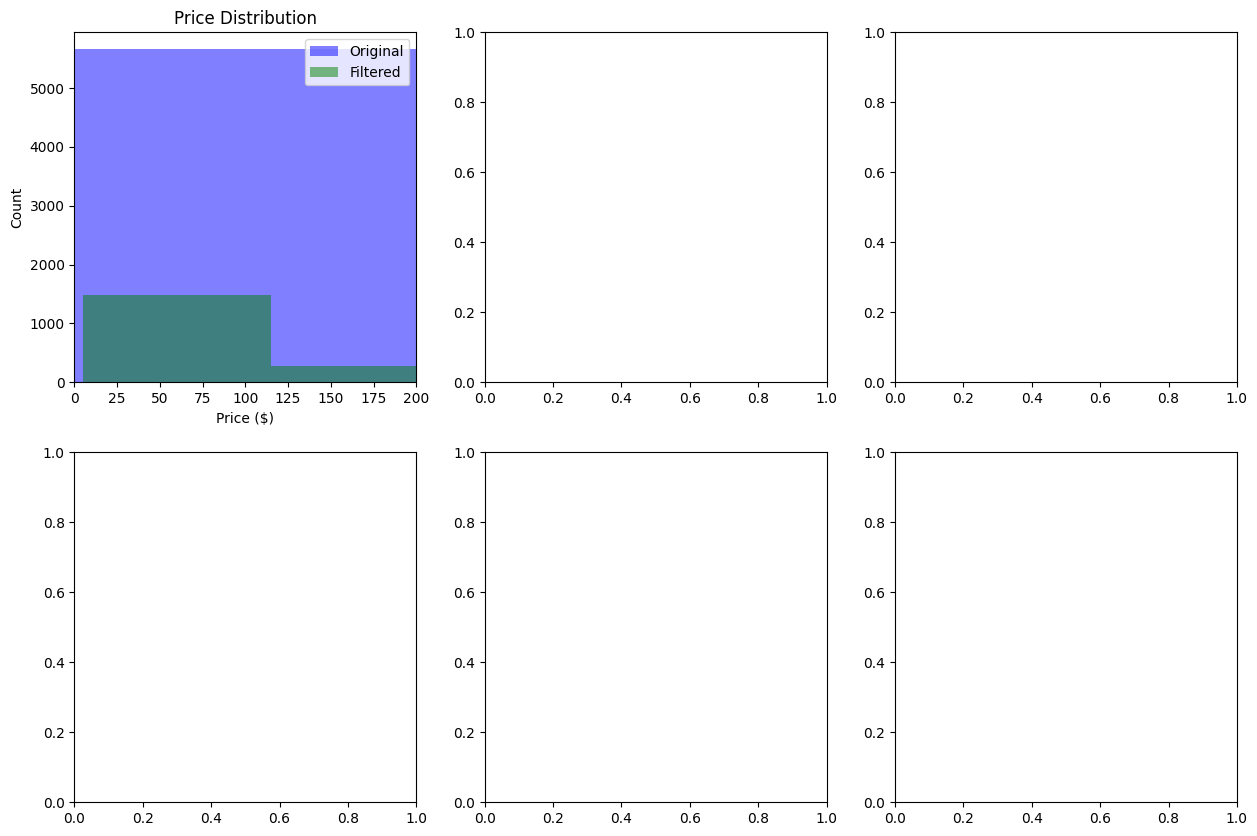

In [17]:
# Cell 7: Visualize Filter Results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_filtering_results(original_metrics, filtered_metrics):
    """Create visualizations of the filtering process."""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Price distribution comparison
    ax = axes[0, 0]
    ax.hist(original_metrics['price_current'], bins=50, alpha=0.5, label='Original', color='blue')
    ax.hist(filtered_metrics['price_current'], bins=50, alpha=0.5, label='Filtered', color='green')
    ax.set_xlabel('Price ($)')
    ax.set_ylabel('Count')
    ax.set_title('Price Distribution')
    ax.legend()
    ax.set_xlim(0, 200)  # Focus on reasonable range
    
    # 2. Dollar volume distribution
    ax = axes[0, 1]
    ax.hist(np.log10(original_metrics['dollar_volume_30d']), bins=50, alpha=0.5, label='Original', color='blue')
    ax.hist(np.log10(filtered_metrics['dollar_volume_30d']), bins=50, alpha=0.5, label='Filtered', color='green')
    ax.set_xlabel('Log10(Dollar Volume)')
    ax.set_ylabel('Count')
    ax.set_title('Dollar Volume Distribution')
    ax.legend()
    
    # 3. Missing data distribution
    ax = axes[0, 2]
    ax.hist(original_metrics['missing_pct_1y']*100, bins=30, alpha=0.5, label='Original', color='blue')
    ax.hist(filtered_metrics['missing_pct_1y']*100, bins=30, alpha=0.5, label='Filtered', color='green')
    ax.set_xlabel('Missing Data (%)')
    ax.set_ylabel('Count')
    ax.set_title('Data Quality')
    ax.legend()
    
    # 4. Price vs Volume scatter
    ax = axes[1, 0]
    ax.scatter(original_metrics['price_current'], 
              original_metrics['dollar_volume_30d']/1e6,
              alpha=0.3, s=10, label='Removed', color='red')
    ax.scatter(filtered_metrics['price_current'], 
              filtered_metrics['dollar_volume_30d']/1e6,
              alpha=0.5, s=20, label='Passed', color='green')
    ax.set_xlabel('Price ($)')
    ax.set_ylabel('Dollar Volume ($M)')
    ax.set_title('Price vs Volume')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 100)
    ax.legend()
    
    # 5. Filter cascade waterfall
    ax = axes[1, 1]
    filter_stages = ['Original', 'Price', 'Volume', 'History', 'Quality', 'Final']
    filter_counts = [
        len(original_metrics),
        len(original_metrics[original_metrics['price_current'] >= 5]),
        len(filtered_metrics) + 20,  # Approximate intermediate stages
        len(filtered_metrics) + 10,
        len(filtered_metrics) + 5,
        len(filtered_metrics)
    ]
    colors = ['blue'] + ['red']*4 + ['green']
    ax.bar(filter_stages, filter_counts, color=colors, alpha=0.6)
    ax.set_ylabel('Number of Stocks')
    ax.set_title('Filter Cascade')
    ax.tick_params(axis='x', rotation=45)
    
    # 6. Sector distribution (if available)
    ax = axes[1, 2]
    if 'sector' in filtered_metrics.columns:
        sector_counts = filtered_metrics['sector'].value_counts().head(10)
        ax.barh(range(len(sector_counts)), sector_counts.values)
        ax.set_yticks(range(len(sector_counts)))
        ax.set_yticklabels(sector_counts.index)
        ax.set_xlabel('Count')
        ax.set_title('Top Sectors (Filtered)')
    else:
        ax.text(0.5, 0.5, 'No sector data available', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Sector Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 Summary Statistics Comparison:")
    print("-" * 60)
    print(f"{'Metric':<30} {'Original':>15} {'Filtered':>15}")
    print("-" * 60)
    print(f"{'Total Stocks':<30} {len(original_metrics):>15} {len(filtered_metrics):>15}")
    print(f"{'Avg Price':<30} ${original_metrics['price_current'].mean():>14.2f} ${filtered_metrics['price_current'].mean():>14.2f}")
    print(f"{'Median Price':<30} ${original_metrics['price_current'].median():>14.2f} ${filtered_metrics['price_current'].median():>14.2f}")
    print(f"{'Avg Dollar Volume (M)':<30} ${original_metrics['dollar_volume_30d'].mean()/1e6:>14.1f} ${filtered_metrics['dollar_volume_30d'].mean()/1e6:>14.1f}")
    print(f"{'Min Dollar Volume (M)':<30} ${original_metrics['dollar_volume_30d'].min()/1e6:>14.1f} ${filtered_metrics['dollar_volume_30d'].min()/1e6:>14.1f}")

# Create visualizations
visualize_filtering_results(stock_metrics, filtered_stocks)

In [18]:
# Cell 8: Rank and Score Filtered Stocks
def rank_filtered_stocks(filtered_df):
    """Rank stocks by multiple criteria for prioritization."""
    
    # Create composite score based on multiple factors
    df = filtered_df.copy()
    
    # Normalize metrics to 0-1 scale
    df['volume_score'] = df['dollar_volume_30d'].rank(pct=True)
    df['quality_score'] = 1 - df['missing_pct_1y']  # Lower missing is better
    df['consistency_score'] = df['trading_days_pct']
    df['liquidity_score'] = df['volume_mean_30d'].rank(pct=True)
    
    # Calculate composite score (you can adjust weights)
    weights = {
        'volume_score': 0.35,
        'quality_score': 0.25,
        'consistency_score': 0.20,
        'liquidity_score': 0.20
    }
    
    df['composite_score'] = sum(df[col] * weight for col, weight in weights.items())
    
    # Rank by composite score
    df['rank'] = df['composite_score'].rank(ascending=False, method='dense').astype(int)
    
    # Sort by rank
    df = df.sort_values('rank')
    
    print("Top 20 Stocks by Composite Score:")
    print("-" * 100)
    print(f"{'Rank':<6} {'Symbol':<8} {'Price':<10} {'Dollar Vol (M)':<15} {'Quality':<10} {'Score':<10}")
    print("-" * 100)
    
    for _, row in df.head(20).iterrows():
        print(f"{row['rank']:<6} {row['symbol']:<8} ${row['price_current']:<9.2f} "
              f"${row['dollar_volume_30d']/1e6:<14.1f} "
              f"{row['quality_score']:<9.3f} {row['composite_score']:<9.3f}")
    
    return df

# Rank the filtered stocks
ranked_stocks = rank_filtered_stocks(filtered_stocks)

Top 20 Stocks by Composite Score:
----------------------------------------------------------------------------------------------------
Rank   Symbol   Price      Dollar Vol (M)  Quality    Score     
----------------------------------------------------------------------------------------------------
1      TSLA     $308.27    $32237.4        1.000     0.999    
2      NVDA     $177.87    $28566.8        1.000     0.999    
3      AAPL     $207.33    $10991.9        1.000     0.998    
4      AMD      $176.31    $8562.4         1.000     0.998    
5      AMZN     $234.11    $9750.9         1.000     0.997    
6      GOOGL    $191.90    $7859.3         1.000     0.996    
7      HOOD     $103.05    $4852.5         1.000     0.996    
8      INTC     $19.80     $1901.1         1.000     0.995    
9      SMCI     $58.97     $2193.6         1.000     0.994    
10     GOOG     $192.86    $5325.6         1.000     0.994    
11     HIMS     $66.18     $2160.3         1.000     0.993    
12    

In [19]:
# Cell 9: Save Coarse Filtered Universe
def save_coarse_universe(filtered_df, output_dir="data/coarse_filtered"):
    """Save the coarse filtered universe for next stage."""
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Prepare data for saving
    save_df = filtered_df[['symbol', 'rank', 'composite_score', 
                           'price_current', 'dollar_volume_30d', 
                           'total_days', 'missing_pct_1y']].copy()
    
    # Add metadata columns
    save_df['stage'] = 'coarse'
    save_df['filter_date'] = datetime.now().strftime('%Y-%m-%d')
    
    # Save as parquet
    output_file = output_path / "coarse_universe.parquet"
    save_df.to_parquet(output_file, compression='snappy')
    print(f"✓ Saved coarse universe to {output_file}")
    
    # Save detailed metrics for analysis
    metrics_file = output_path / "coarse_metrics.parquet"
    filtered_df.to_parquet(metrics_file, compression='snappy')
    print(f"✓ Saved detailed metrics to {metrics_file}")
    
    # Save symbol list for easy access
    symbols_file = output_path / "symbols.txt"
    with open(symbols_file, 'w') as f:
        for symbol in save_df['symbol']:
            f.write(f"{symbol}\n")
    print(f"✓ Saved symbol list to {symbols_file}")
    
    # Save configuration
    config_file = output_path / "coarse_config.json"
    with open(config_file, 'w') as f:
        json.dump(coarse_config, f, indent=2)
    print(f"✓ Saved configuration to {config_file}")
    
    # Create summary report
    summary = {
        'total_stocks_input': len(stock_metrics),
        'total_stocks_output': len(filtered_df),
        'pass_rate': f"{len(filtered_df)/len(stock_metrics)*100:.1f}%",
        'filter_date': datetime.now().isoformat(),
        'top_10_symbols': save_df.head(10)['symbol'].tolist(),
        'statistics': {
            'avg_price': float(filtered_df['price_current'].mean()),
            'median_price': float(filtered_df['price_current'].median()),
            'avg_dollar_volume': float(filtered_df['dollar_volume_30d'].mean()),
            'min_dollar_volume': float(filtered_df['dollar_volume_30d'].min()),
            'max_dollar_volume': float(filtered_df['dollar_volume_30d'].max()),
        }
    }
    
    summary_file = output_path / "summary.json"
    with open(summary_file, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"✓ Saved summary to {summary_file}")
    
    return save_df

# Save the results
saved_universe = save_coarse_universe(ranked_stocks)

print(f"\n📁 All files saved to data/coarse_filtered/")
print(f"   - {len(saved_universe)} stocks passed coarse filtering")

✓ Saved coarse universe to data\coarse_filtered\coarse_universe.parquet
✓ Saved detailed metrics to data\coarse_filtered\coarse_metrics.parquet
✓ Saved symbol list to data\coarse_filtered\symbols.txt
✓ Saved configuration to data\coarse_filtered\coarse_config.json
✓ Saved summary to data\coarse_filtered\summary.json

📁 All files saved to data/coarse_filtered/
   - 1961 stocks passed coarse filtering


In [20]:
# Cell 11: Performance Report
def generate_performance_report(original_df, filtered_df):
    """Generate a performance report of the filtering process."""
    
    print("\n" + "="*60)
    print("COARSE FILTERING PERFORMANCE REPORT")
    print("="*60)
    
    # Efficiency metrics
    print("\n📊 EFFICIENCY METRICS:")
    print(f"  Input stocks: {len(original_df)}")
    print(f"  Output stocks: {len(filtered_df)}")
    print(f"  Reduction: {(1 - len(filtered_df)/len(original_df))*100:.1f}%")
    print(f"  Pass rate: {len(filtered_df)/len(original_df)*100:.1f}%")
    
    # Quality improvements
    print("\n✅ QUALITY IMPROVEMENTS:")
    print(f"  Avg missing data: {original_df['missing_pct_1y'].mean()*100:.2f}% → "
          f"{filtered_df['missing_pct_1y'].mean()*100:.2f}%")
    print(f"  Avg dollar volume: ${original_df['dollar_volume_30d'].mean()/1e6:.1f}M → "
          f"${filtered_df['dollar_volume_30d'].mean()/1e6:.1f}M")
    print(f"  Min dollar volume: ${original_df['dollar_volume_30d'].min()/1e6:.1f}M → "
          f"${filtered_df['dollar_volume_30d'].min()/1e6:.1f}M")
    
    # Universe characteristics
    print("\n🎯 FILTERED UNIVERSE CHARACTERISTICS:")
    print(f"  Price range: ${filtered_df['price_current'].min():.2f} - ${filtered_df['price_current'].max():.2f}")
    print(f"  Median price: ${filtered_df['price_current'].median():.2f}")
    print(f"  Total dollar volume: ${filtered_df['dollar_volume_30d'].sum()/1e9:.1f}B")
    print(f"  Avg market cap (est): ${filtered_df['dollar_volume_30d'].mean()*100/1e6:.0f}M")
    
    # Top stocks
    print("\n🏆 TOP 10 STOCKS BY COMPOSITE SCORE:")
    for i, row in filtered_df.head(10).iterrows():
        print(f"  {row['rank']:2}. {row['symbol']:6} - Score: {row['composite_score']:.3f}, "
              f"Price: ${row['price_current']:.2f}, Volume: ${row['dollar_volume_30d']/1e6:.1f}M")
    
    print("\n" + "="*60)
    print("✅ STAGE 2: COARSE FILTERING COMPLETE")

In [21]:
generate_performance_report(stock_metrics, ranked_stocks)
print("All steps completed successfully!")


COARSE FILTERING PERFORMANCE REPORT

📊 EFFICIENCY METRICS:
  Input stocks: 5665
  Output stocks: 1961
  Reduction: 65.4%
  Pass rate: 34.6%

✅ QUALITY IMPROVEMENTS:
  Avg missing data: 0.00% → 0.00%
  Avg dollar volume: $96.5M → $254.2M
  Min dollar volume: $0.0M → $10.1M

🎯 FILTERED UNIVERSE CHARACTERISTICS:
  Price range: $5.02 - $5504.06
  Median price: $51.64
  Total dollar volume: $498.4B
  Avg market cap (est): $25417M

🏆 TOP 10 STOCKS BY COMPOSITE SCORE:
   1. TSLA   - Score: 0.999, Price: $308.27, Volume: $32237.4M
   2. NVDA   - Score: 0.999, Price: $177.87, Volume: $28566.8M
   3. AAPL   - Score: 0.998, Price: $207.33, Volume: $10991.9M
   4. AMD    - Score: 0.998, Price: $176.31, Volume: $8562.4M
   5. AMZN   - Score: 0.997, Price: $234.11, Volume: $9750.9M
   6. GOOGL  - Score: 0.996, Price: $191.90, Volume: $7859.3M
   7. HOOD   - Score: 0.996, Price: $103.05, Volume: $4852.5M
   8. INTC   - Score: 0.995, Price: $19.80, Volume: $1901.1M
   9. SMCI   - Score: 0.994, Price: